In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GeBP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn030741,MASNRRPETEAQAGSSSEEEEGSSEENEDQEVSESESEEEKAPAPT...,388,1
1,Achn056961,MASEEDPTVYGEEDLDEDDEEDSEEDEGLTIPTSNPPQPDLDDDLD...,401,1
2,Achn082261,MAPNRLPEAEAQGSPSSDEEVEGESSEENESQSESDEEEDKTSTPS...,363,1
3,Achn111841,MASSRRPETEAQSGSSSEEEGSSEENEDQEVSESEEDKAPTPTRQK...,385,1
4,Achn176771,MPREIKNQNGKNVAQKPRIPTTPSSKQPAEKLPDKAAVETEQDPEV...,260,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
933,0.030172,0.000000,0.012931,0.010776,0.002155,0.021552,0.000000,0.004310,0.008621,0.004310,...,0.000000,0.002155,0.004310,0.002155,0.000000,0.000000,0.000000,0.0,0.0,0.0
1219,0.024324,0.002703,0.008108,0.002703,0.000000,0.013514,0.000000,0.000000,0.005405,0.008108,...,0.002703,0.000000,0.000000,0.002703,0.000000,0.002703,0.000000,0.0,0.0,0.0
1526,0.011765,0.000000,0.007843,0.003922,0.003922,0.000000,0.003922,0.007843,0.007843,0.003922,...,0.000000,0.003922,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0,0.0
1840,0.028571,0.000000,0.010714,0.003571,0.003571,0.000000,0.003571,0.000000,0.000000,0.007143,...,0.003571,0.003571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2110,0.004967,0.001656,0.004967,0.004967,0.000000,0.006623,0.001656,0.003311,0.000000,0.004967,...,0.003311,0.001656,0.001656,0.003311,0.000000,0.001656,0.001656,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2482, 441)
X_test: (621, 441)
y_train: (2482,)
y_test: (621,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - accuracy: 0.4844 - loss: 0.6935

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6222 - loss: 0.6846   

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6398 - loss: 0.6802 - val_accuracy: 0.6841 - val_loss: 0.5653


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5781 - loss: 0.6298

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8138 - loss: 0.4731 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8204 - loss: 0.4631 - val_accuracy: 0.9396 - val_loss: 0.1644


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9219 - loss: 0.2154

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9477 - loss: 0.1513 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9478 - loss: 0.1506 - val_accuracy: 0.9598 - val_loss: 0.1164


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0826

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9663 - loss: 0.0994 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9656 - loss: 0.1007 - val_accuracy: 0.9155 - val_loss: 0.1816


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9219 - loss: 0.2202

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9633 - loss: 0.1108 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.1087 - val_accuracy: 0.9557 - val_loss: 0.1138


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0773

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0800 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9723 - loss: 0.0795 - val_accuracy: 0.9678 - val_loss: 0.0971


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0660

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0667 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9798 - loss: 0.0667 - val_accuracy: 0.9738 - val_loss: 0.0832


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0643

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0468 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0478 - val_accuracy: 0.9779 - val_loss: 0.0844


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0398

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0358 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0368 - val_accuracy: 0.9759 - val_loss: 0.0775


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0595

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0408 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0398 - val_accuracy: 0.9759 - val_loss: 0.0798


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0513

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0357 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0348 - val_accuracy: 0.9759 - val_loss: 0.0768


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0164

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0292 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0293 - val_accuracy: 0.9658 - val_loss: 0.1142


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0085

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0439 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0443 - val_accuracy: 0.9759 - val_loss: 0.0799


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0844

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0504 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0499 - val_accuracy: 0.9658 - val_loss: 0.1015


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0093

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0324 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0315 - val_accuracy: 0.9718 - val_loss: 0.0775


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0248

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0181 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0182 - val_accuracy: 0.9779 - val_loss: 0.0756


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0142 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0151 - val_accuracy: 0.9759 - val_loss: 0.0958


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0698

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0197 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0188 - val_accuracy: 0.9759 - val_loss: 0.0802



[Train Accuracy: 99.75% - Test Accuracy: 96.94%]


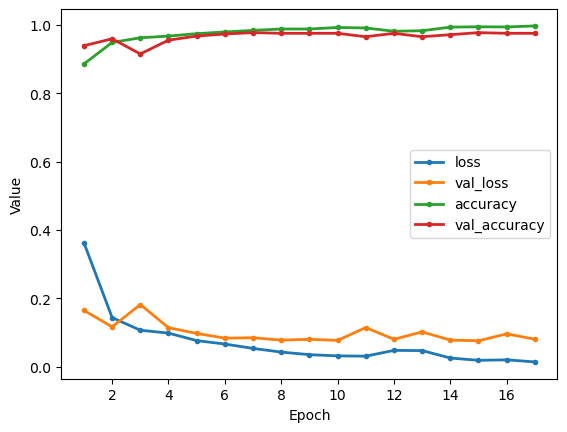

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
933,0.008639,0.0,0.000000,0.000000,0.000000,0.008639,0.000000,0.00216,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,0.010840,0.0,0.000000,0.000000,0.000000,0.002710,0.000000,0.00000,0.0,0.005420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003937,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,0.003584,0.0,0.000000,0.003584,0.003584,0.000000,0.000000,0.00000,0.0,0.007168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.000000,0.0,0.001658,0.001658,0.000000,0.001658,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2482, 8604)
X_test: (621, 8604)
y_train: (2482,)
y_test: (621,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,202,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,246,145 (8.57 MB)

 Trainable params: 2,246,145 (8.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20s 672ms/step - accuracy: 0.5000 - loss: 0.6931

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4968 - loss: 0.6931   

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5080 - loss: 0.6929

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5253 - loss: 0.6925

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5470 - loss: 0.6913

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5775 - loss: 0.6887 - val_accuracy: 0.8773 - val_loss: 0.6089


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8750 - loss: 0.6120

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9210 - loss: 0.5877 

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9303 - loss: 0.5649

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9332 - loss: 0.5379

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9369 - loss: 0.5086

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9387 - loss: 0.4923 - val_accuracy: 0.9779 - val_loss: 0.1062


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0868

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.0658 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9939 - loss: 0.0568

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9922 - loss: 0.0528

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9911 - loss: 0.0508

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9910 - loss: 0.0505 - val_accuracy: 0.9799 - val_loss: 0.0699


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.0189

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0100 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0125

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0124

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9963 - loss: 0.0118 - val_accuracy: 0.9799 - val_loss: 0.0621


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0020

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0025 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0032

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0038

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0040 - val_accuracy: 0.9779 - val_loss: 0.0673


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0025

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0026

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9839 - val_loss: 0.0821


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0013

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0020 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9859 - val_loss: 0.0703


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.1379e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2740e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0347e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9107e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7092e-04 - val_accuracy: 0.9859 - val_loss: 0.0718


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0011

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0794e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4875e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1077e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8005e-04 - val_accuracy: 0.9859 - val_loss: 0.0834


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.8846e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9289e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8121e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7295e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6229e-04 - val_accuracy: 0.9859 - val_loss: 0.0782


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.3392e-05

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3912e-04 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5628e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6893e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7247e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7283e-04 - val_accuracy: 0.9859 - val_loss: 0.0793


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.4490e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9232e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9280e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0054e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0646e-04 - val_accuracy: 0.9859 - val_loss: 0.0811


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8790e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9374e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8074e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7856e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7541e-04 - val_accuracy: 0.9859 - val_loss: 0.0825


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.2213e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1530e-04 

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8411e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6765e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6319e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6231e-04 - val_accuracy: 0.9859 - val_loss: 0.0860


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.6532e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5961e-04 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4004e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3360e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3098e-04 - val_accuracy: 0.9839 - val_loss: 0.0840


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.0038e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0696e-04 

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0161e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4556e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2978e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.3482e-05 - val_accuracy: 0.9859 - val_loss: 0.0894


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.0889e-05

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4614e-05 

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1569e-05

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3082e-05

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.3468e-05 - val_accuracy: 0.9839 - val_loss: 0.0927



[Train Accuracy: 100.00% - Test Accuracy: 98.07%]


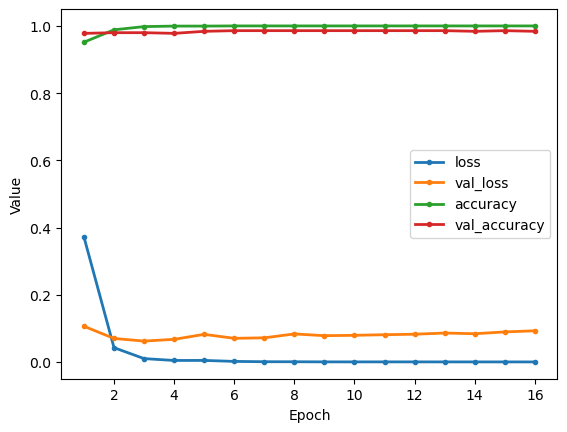

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
933,0.002165,0.0,0.0,0.0,0.0,0.002165,0.0,0.002165,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,0.005435,0.0,0.0,0.0,0.0,0.002717,0.0,0.000000,0.0,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1840,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.003597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      33,118,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,159,425 (126.49 MB)

 Trainable params: 33,159,425 (126.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 27s 877ms/step - accuracy: 0.4844 - loss: 0.6931

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4922 - loss: 0.6930  

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4896 - loss: 0.6931

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4873 - loss: 0.6930

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4861 - loss: 0.6930

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4901 - loss: 0.6930

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4947 - loss: 0.6930

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4974 - loss: 0.6930

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5005 - loss: 0.6929

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5033 - loss: 0.6929

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5052 - loss: 0.6928

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5068 - loss: 0.6927

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5084 - loss: 0.6927

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5096 - loss: 0.6926

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5110 - loss: 0.6925

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5132 - loss: 0.6924

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5161 - loss: 0.6923

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5197 - loss: 0.6922

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5237 - loss: 0.6921

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5280 - loss: 0.6919

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5326 - loss: 0.6918

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5373 - loss: 0.6916

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5416 - loss: 0.6914

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5458 - loss: 0.6912

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5499 - loss: 0.6910

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5541 - loss: 0.6908

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5584 - loss: 0.6905

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5627 - loss: 0.6902

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5671 - loss: 0.6899

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5714 - loss: 0.6896

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5756 - loss: 0.6892

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5834 - loss: 0.6886 - val_accuracy: 0.8531 - val_loss: 0.6196


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9375 - loss: 0.5970

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9219 - loss: 0.5976 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9201 - loss: 0.5965

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9206 - loss: 0.5951

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9221 - loss: 0.5934

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9234 - loss: 0.5913

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9251 - loss: 0.5892

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9271 - loss: 0.5868

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9294 - loss: 0.5843

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9318 - loss: 0.5815

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9341 - loss: 0.5785

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9360 - loss: 0.5756

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9378 - loss: 0.5726

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9394 - loss: 0.5695

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9408 - loss: 0.5662

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9420 - loss: 0.5628

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9432 - loss: 0.5594

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9442 - loss: 0.5558

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9451 - loss: 0.5523

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9460 - loss: 0.5487

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9468 - loss: 0.5451

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9476 - loss: 0.5413

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9484 - loss: 0.5375

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9491 - loss: 0.5336

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9498 - loss: 0.5297

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9505 - loss: 0.5257

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9511 - loss: 0.5217

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9517 - loss: 0.5177

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9523 - loss: 0.5137

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9529 - loss: 0.5096

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9535 - loss: 0.5056

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9540 - loss: 0.5018

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9544 - loss: 0.4982 - val_accuracy: 0.9557 - val_loss: 0.1482


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 0.0658

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 0.0712 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9983 - loss: 0.0754

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9977 - loss: 0.0760

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9976 - loss: 0.0756

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9975 - loss: 0.0746

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9976 - loss: 0.0733

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9976 - loss: 0.0719

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9977 - loss: 0.0705

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9976 - loss: 0.0694

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9976 - loss: 0.0682

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9976 - loss: 0.0670

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9976 - loss: 0.0658

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9976 - loss: 0.0647

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9976 - loss: 0.0636

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9976 - loss: 0.0626

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9977 - loss: 0.0616

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9977 - loss: 0.0606

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9977 - loss: 0.0597

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9978 - loss: 0.0588

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9978 - loss: 0.0579

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9978 - loss: 0.0570

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9979 - loss: 0.0562

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9979 - loss: 0.0554

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9979 - loss: 0.0547

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0539

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0532

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0525

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0519

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0512

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9980 - loss: 0.0506

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9980 - loss: 0.0500

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9981 - loss: 0.0495 - val_accuracy: 0.9879 - val_loss: 0.0558


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.0076

 2/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 1.0000 - loss: 0.0071

 3/32 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0069

 4/32 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0069

 5/32 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0069

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0069

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 0.0069

 8/32 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.0000 - loss: 0.0069

 9/32 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 1.0000 - loss: 0.0069 

10/32 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 0.0068

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0067

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 0.0067

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 0.0066

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0065

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.0065

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0064

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 0.0064

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0063

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0063

20/32 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0062

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0062

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0061

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0061

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0061

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0060

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0060

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0059

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0059

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0059

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0058

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0058

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9799 - val_loss: 0.0511


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0029

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 1.0000 - loss: 0.0027 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0026

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0025

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0024

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0024

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0024

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0023

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0023

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0023

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0023

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0023

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0022

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0022

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0022

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0022

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0022

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0022

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0022

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0022

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9799 - val_loss: 0.0488


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 7.5225e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 8.8328e-04 

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 9.3765e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 9.7031e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0010    

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 0.0010

 7/32 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0010

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0011

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0011

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0011

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0011

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9799 - val_loss: 0.0512


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 7.9002e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 8.0561e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 8.6181e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 8.6048e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 8.4938e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 8.6231e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7645e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.8157e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.8512e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.8293e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7854e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7723e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7511e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7312e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.7007e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.6715e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.6348e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.5897e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 8.5449e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.4969e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.4619e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.4260e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.3930e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.3544e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.3145e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.2722e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.2311e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.1920e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.1525e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.1144e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.0757e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 8.0050e-04 - val_accuracy: 0.9799 - val_loss: 0.0501


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 5.6821e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 5.2919e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 4.9786e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 4.8338e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 4.8773e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8901e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.9110e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8991e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8870e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8664e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8545e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8545e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8480e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8596e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8555e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8465e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8307e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 4.8149e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.8045e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7951e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7847e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7764e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7652e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7539e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7454e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7347e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7241e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7145e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.7046e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.6922e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 4.6794e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 4.6560e-04 - val_accuracy: 0.9779 - val_loss: 0.0538


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 2.8678e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 2.7396e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 2.8061e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.8124e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 2.8553e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 2.8852e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 2.9042e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.9623e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.9992e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.0525e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.1214e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.1695e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.2066e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.2401e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.2666e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.2946e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.3145e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.3393e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.3567e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.3696e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.3783e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.3898e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.3971e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4003e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4035e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4045e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4047e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.4036e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4026e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4034e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 3.4033e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 3.4030e-04 - val_accuracy: 0.9779 - val_loss: 0.0545


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 2.3993e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 2.6125e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.5347e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.5419e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 2.4994e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 2.4409e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 2.4116e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 2.3825e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 2.3575e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.3424e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.3618e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.3718e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 2.3907e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4056e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4186e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4335e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4502e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 2.4640e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4738e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4806e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4850e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4901e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4943e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4967e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4973e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.4995e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.5021e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.5042e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.5057e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.5062e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 2.5066e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 2.5072e-04 - val_accuracy: 0.9779 - val_loss: 0.0548


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 2.1373e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.1636e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.1053e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.0376e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.0246e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9922e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9625e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9361e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9555e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9814e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.9967e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0155e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0242e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0290e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0304e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0272e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0212e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 2.0144e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0078e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.0008e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9927e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9849e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9756e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9685e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9617e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9563e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9518e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9507e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9489e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9469e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.9451e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 1.9417e-04 - val_accuracy: 0.9799 - val_loss: 0.0542


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 1.3001e-04

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 1.2853e-04

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.3056e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.2903e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 1.2713e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2811e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3136e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3404e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3571e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3644e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3701e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3788e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.3952e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4072e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4134e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4156e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4206e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4239e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4290e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4351e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4411e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4447e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4472e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4482e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4480e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4476e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4467e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4451e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4439e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4424e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4405e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 1.0000 - loss: 1.4371e-04 - val_accuracy: 0.9779 - val_loss: 0.0577


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 1.0000 - loss: 9.7417e-05

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 9.8281e-05

 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.0191e-04

 4/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 1.0794e-04

 5/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 1.1083e-04

 6/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.1244e-04

 7/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.1906e-04

 8/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2491e-04

 9/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2872e-04

10/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3166e-04

11/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3392e-04

12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3666e-04

13/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.3856e-04

14/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4092e-04

15/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4245e-04

16/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4399e-04

17/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4511e-04

18/32 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.4591e-04

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4687e-04

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4750e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4785e-04

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4809e-04

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4816e-04

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4820e-04

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4812e-04

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4797e-04

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4780e-04

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4774e-04

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4759e-04

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4740e-04

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.4716e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.4694e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 1.4674e-04 - val_accuracy: 0.9799 - val_loss: 0.0554



[Train Accuracy: 100.00% - Test Accuracy: 98.71%]


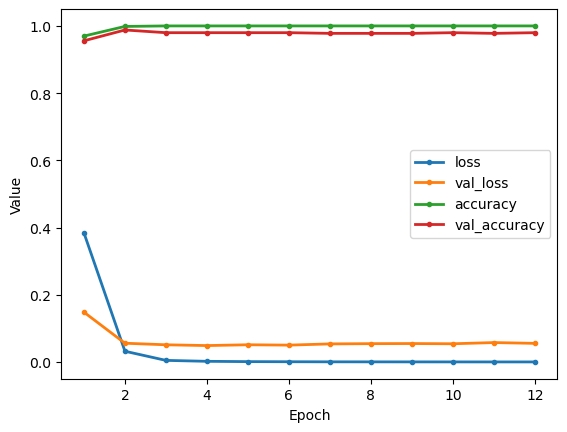

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/GeBP/report_R3J3GCYQ.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################